In [62]:
import sys
print(sys.executable)

/usr/bin/python


In [63]:
import os
import sys
if os.getcwd().endswith('visualize'):
    os.chdir('..')
sys.path.append(os.getcwd())
from loader.dataloader import VideoDataSet,VideoDataLoader
import torch


dataset ="50salads"
split_test = "test.split2.bundle"
split_train = "train.split2.bundle"

default_path="./data/data/"
knowns = 14
unknowns = 5
prototypes = 30
video_dataset_test = VideoDataSet(dataset=dataset,
                               split=split_test,
                               default_path=default_path,
                               knowns=knowns,
                               unknowns=unknowns,
                               total_classes=knowns + prototypes)
data_loader_test = VideoDataLoader(video_dataset_test, batch_size=1, shuffle=True)

video_dataset_train = VideoDataSet(dataset=dataset,
                               split=split_train,
                               default_path=default_path,
                               knowns=knowns,
                               unknowns=unknowns,
                               total_classes=knowns + prototypes)
data_loader_train = VideoDataLoader(video_dataset_train, batch_size=1, shuffle=False)

tensor([True, True, True,  ..., True, True, True])
tensor([True, True, True,  ..., True, True, True])
tensor([True, True, True,  ..., True, True, True])
tensor([True, True, True,  ..., True, True, True])
tensor([True, True, True,  ..., True, True, True])
tensor([True, True, True,  ..., True, True, True])
tensor([True, True, True,  ..., True, True, True])
tensor([True, True, True,  ..., True, True, True])
tensor([True, True, True,  ..., True, True, True])
tensor([True, True, True,  ..., True, True, True])
tensor([True, True, True,  ..., True, True, True])
tensor([True, True, True,  ..., True, True, True])
tensor([True, True, True,  ..., True, True, True])
tensor([True, True, True,  ..., True, True, True])
tensor([True, True, True,  ..., True, True, True])
tensor([True, True, True,  ..., True, True, True])
tensor([True, True, True,  ..., True, True, True])
tensor([True, True, True,  ..., True, True, True])
tensor([True, True, True,  ..., True, True, True])
tensor([True, True, True,  ...,

In [45]:
from model.bert import ActionBERT, ActionBERTConfig
import torch.nn.functional as F


prototypes = 0
bert_conf = ActionBERTConfig(
     total_classes=knowns + prototypes,
    input_dim=2048,
    d_model=256,
    num_heads=8,
    num_layers=4,
    local_window_size=128,
    window_dilation=32,
    dropout=0)
model = ActionBERT(config=bert_conf)
path = "./output/actionbert_second_try.pth"


state_dict = torch.load(path, map_location=torch.device('cuda'))
model.load_state_dict(state_dict, strict=False)
model = model.to('cuda')
model.eval()
print("Modell erfolgreich geladen.")

def get_model_pred(features,padding_mask):
    unknown_mask = torch.zeros_like(padding_mask).bool()
    res  = model(features,unknown_mask,padding_mask)
    
    
    """pred_dist_start = torch.exp(boundaries[:, :, 0]) - 1
    pred_dist_end   = torch.exp(boundaries[:, :, 1]) - 1
   # pred_dist_start = torch.clamp(pred_dist_start, min=0)
    #pred_dist_end   = torch.clamp(pred_dist_end, min=0)
    
    B, T = pred_dist_start.shape
    device = pred_dist_start.device
    
   
    t_indices = torch.arange(T, device=device).unsqueeze(0).expand(B, T)
    vote_start = torch.round(t_indices - pred_dist_start).long()
    vote_end   = torch.round(t_indices + pred_dist_end ).long()
    """
    softmax_logits = F.softmax(res["refine_logits"], dim=-1)  
    class_labels = torch.argmax(softmax_logits,dim=-1)
    return class_labels
    
def _generate_structured_mask( features, mask_ratio=0.75, block_size=64):
        """
        Structured Masking: Unterteilt das Video in Blöcke der Größe 'block_size'.
        In JEDEM Block werden 'mask_ratio' Prozent maskiert.
        Das verhindert riesige Lücken und garantiert eine gleichmäßige Schwierigkeit.
        """
        B, S, D = features.size()
        mask = torch.zeros((B, S), dtype=torch.bool)

        mask_len_per_block = int(block_size * mask_ratio)

        for t in range(0, S, block_size):
            end_t = min(t + block_size, S)
            actual_block_len = end_t - t

            curr_mask_len = int(actual_block_len * mask_ratio)

            if curr_mask_len == 0:
                continue

            max_start = actual_block_len - curr_mask_len

            if max_start > 0:

                rel_starts = torch.randint(0, max_start, (B,))

                for b in range(B):
                    abs_start = t + rel_starts[b].item()
                    mask[b, abs_start: abs_start + curr_mask_len] = True
            else:
                mask[:, t:end_t] = True

        return mask.to('cuda')


Modell erfolgreich geladen.


In [3]:
for batch_test in data_loader_test:
    features = batch_test["features"]
    unknown_mask = batch_test["unknown_mask"]
    target_truth = batch_test["target_truth"]
    padding_mask = batch_test["padding_mask"]
    labels_dict = batch_test["labels_dict"]
    remap_dict = batch_test["remap_dict"]
    target_start = batch_test['target_start']
    target_end = batch_test['target_end']
   
   
   
   
    
    break
for batch_train in data_loader_train:

   
   
   
   
    
    break

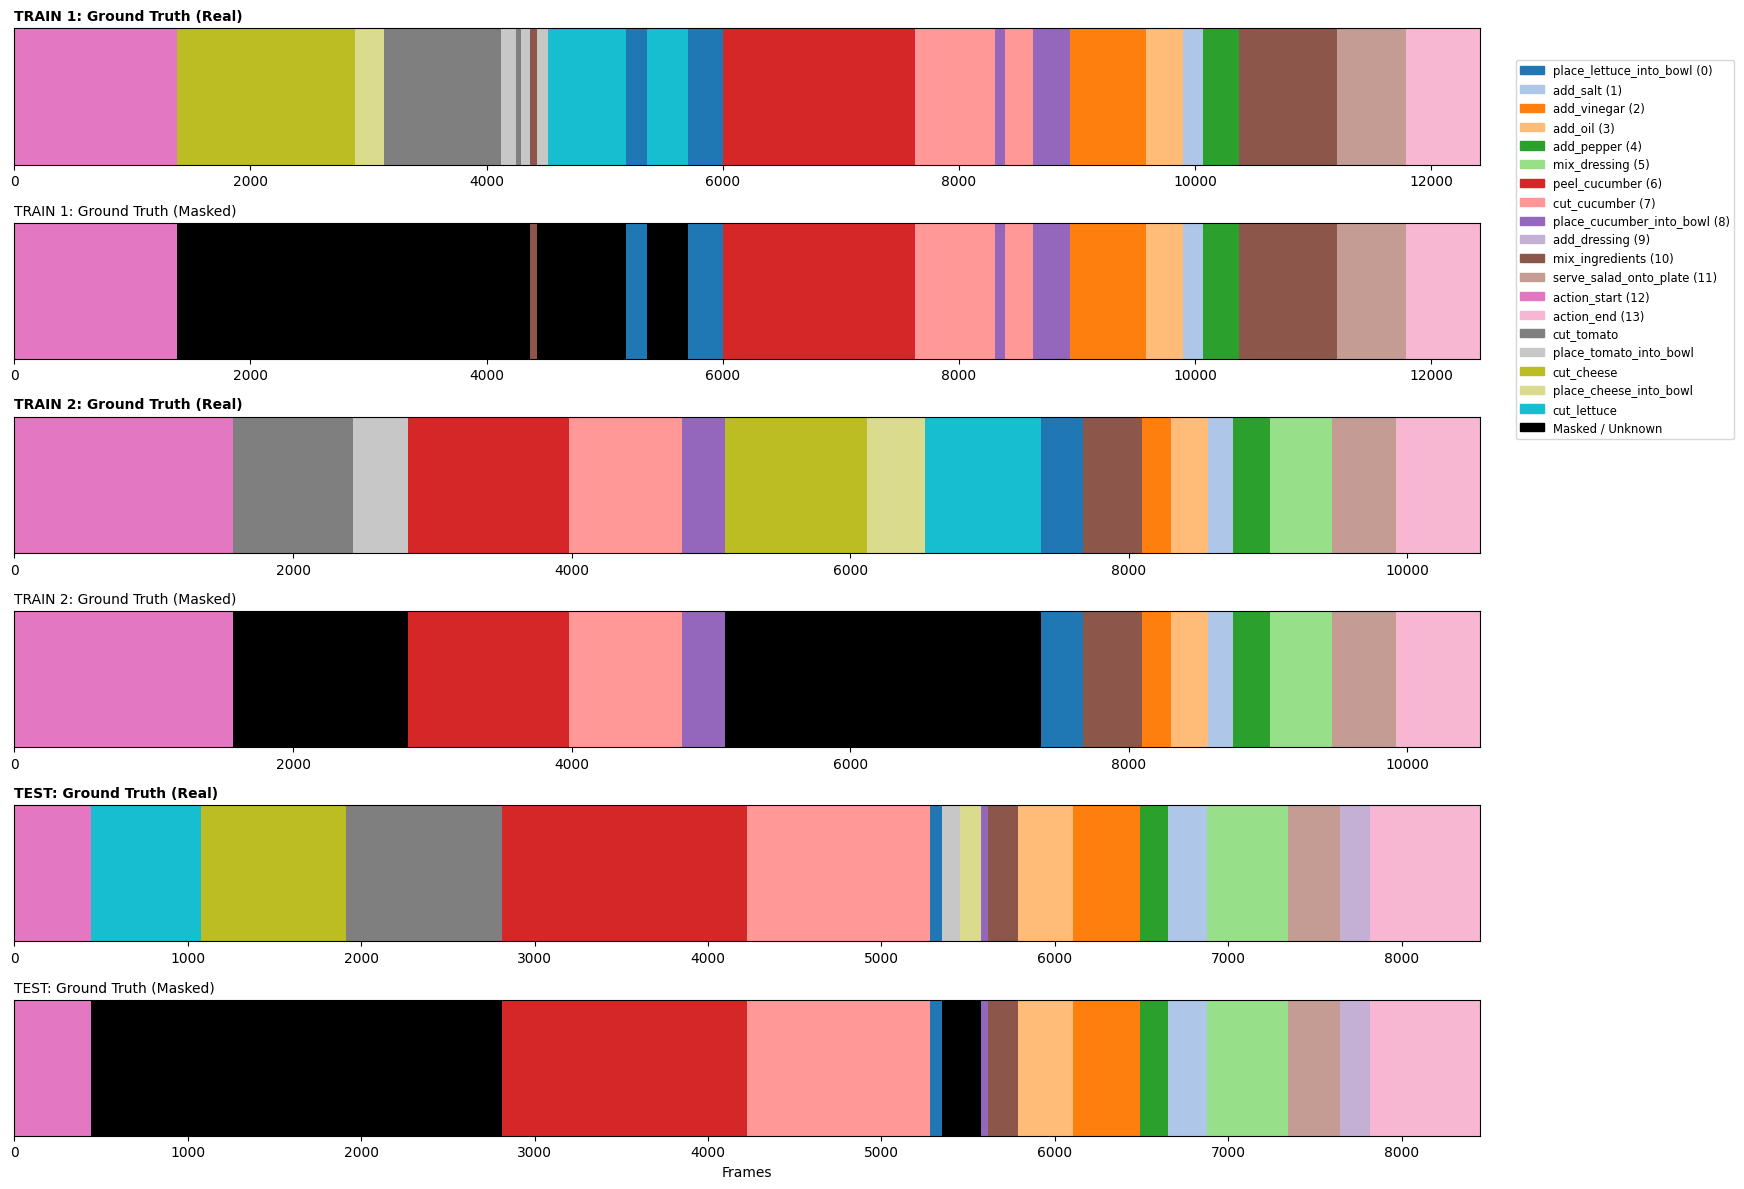

In [48]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import torch
from matplotlib.colors import ListedColormap

# --- KONFIGURATION ---
NUM_KNOWNS = 14 

# 1. Daten holen (Zwei aus Train, einen aus Test)
# Wir nutzen einen Iterator, um zwei unterschiedliche Batches aus dem Training zu ziehen
train_iter = iter(data_loader_train)
for i in range(2):
    b_train1 = next(train_iter)
    b_train2 = next(train_iter)


# Test Batch (Annahme: data_loader_test existiert)
b_test = next(iter(data_loader_test)) 

def process_batch_data(batch):
    """Extrahiert und filtert die Daten eines Batches (nimmt das erste Sample [0])"""
    target_truth = batch["target_truth"][0].cpu().numpy()
    padding_mask = batch["padding_mask"][0].cpu().numpy().astype(bool)
    unknown_mask = batch["unknown_mask"][0].cpu().numpy().astype(bool)
    
    # Filtern: Nur dort, wo kein Padding ist
    gt_real = target_truth[padding_mask]
    unk_valid = unknown_mask[padding_mask]
    
    return gt_real, unk_valid

# Daten für alle drei aufbereiten
gt_tr1, unk_tr1 = process_batch_data(b_train1)
gt_tr2, unk_tr2 = process_batch_data(b_train2)
gt_test, unk_test = process_batch_data(b_test)

# --- 2. Gemeinsames ID-Mapping & Farben ---
raw_dict = b_train1["labels_dict"]
if isinstance(raw_dict, list): raw_dict = raw_dict[0]
id_to_name = {v: k for k, v in raw_dict.items()}

# Maximale ID über alle drei Batches bestimmen für konsistente Farben
max_id = max(gt_tr1.max(), gt_tr2.max(), gt_test.max())

colors1 = plt.get_cmap('tab20').colors
colors2 = plt.get_cmap('tab20b').colors
colors3 = plt.get_cmap('tab20c').colors
base_colors = np.vstack((colors1, colors2, colors3))
while len(base_colors) <= max_id + 1:
    base_colors = np.vstack((base_colors, base_colors))

color_lut = base_colors[:max_id + 2].copy()
BLACK_ID = len(color_lut) - 1
color_lut[BLACK_ID] = [0.0, 0.0, 0.0] 

# --- 3. Maskierung anwenden ---
def apply_mask(gt, unk):
    masked = gt.copy()
    masked[unk] = BLACK_ID
    return masked

gt_tr1_masked = apply_mask(gt_tr1, unk_tr1)
gt_tr2_masked = apply_mask(gt_tr2, unk_tr2)
gt_test_masked = apply_mask(gt_test, unk_test)

# Liste für den Plot (Jetzt 6 Zeilen)
plot_configs = [
    ("TRAIN 1: Ground Truth (Real)", gt_tr1),
    ("TRAIN 1: Ground Truth (Masked)", gt_tr1_masked),
    ("TRAIN 2: Ground Truth (Real)", gt_tr2),
    ("TRAIN 2: Ground Truth (Masked)", gt_tr2_masked),
    ("TEST: Ground Truth (Real)", gt_test),
    ("TEST: Ground Truth (Masked)", gt_test_masked)
]

# --- 4. Plotten ---
# Wir erhöhen die figsize Höhe auf 12, damit 6 Zeilen gut aussehen
fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(15, 12), sharex=False)

for i, (title, data) in enumerate(plot_configs):
    rgb_image = color_lut[data]
    rgb_image = rgb_image[np.newaxis, :, :] 
    
    axs[i].imshow(rgb_image, aspect='auto', interpolation='nearest')
    axs[i].set_title(title, fontsize=10, loc='left', fontweight='bold' if "Real" in title else 'normal')
    axs[i].set_yticks([])
    if i == 5: axs[i].set_xlabel("Frames")

# --- 5. Gemeinsame Legende ---
patches = []
# Knowns
for i in range(NUM_KNOWNS):
    if i in id_to_name:
        patches.append(mpatches.Patch(color=color_lut[i], label=f"{id_to_name[i]} ({i})"))

# Unknowns (IDs > 13) die in IRGENDEINEM der Daten vorkommen
all_ids = np.unique(np.concatenate([gt_tr1, gt_tr2, gt_test]))
for uid in sorted(all_ids):
    if uid >= NUM_KNOWNS and uid != BLACK_ID:
        name = id_to_name.get(uid, f"Cluster {uid}")
        patches.append(mpatches.Patch(color=color_lut[uid], label=f"{name}"))

patches.append(mpatches.Patch(color=[0,0,0], label="Masked / Unknown"))

# Legende platzieren
fig.legend(handles=patches, bbox_to_anchor=(1.01, 0.95), loc='upper left', ncol=1, fontsize='small')

plt.tight_layout()
plt.show()

/tmp/ipykernel_2087/1413804551.py:150: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


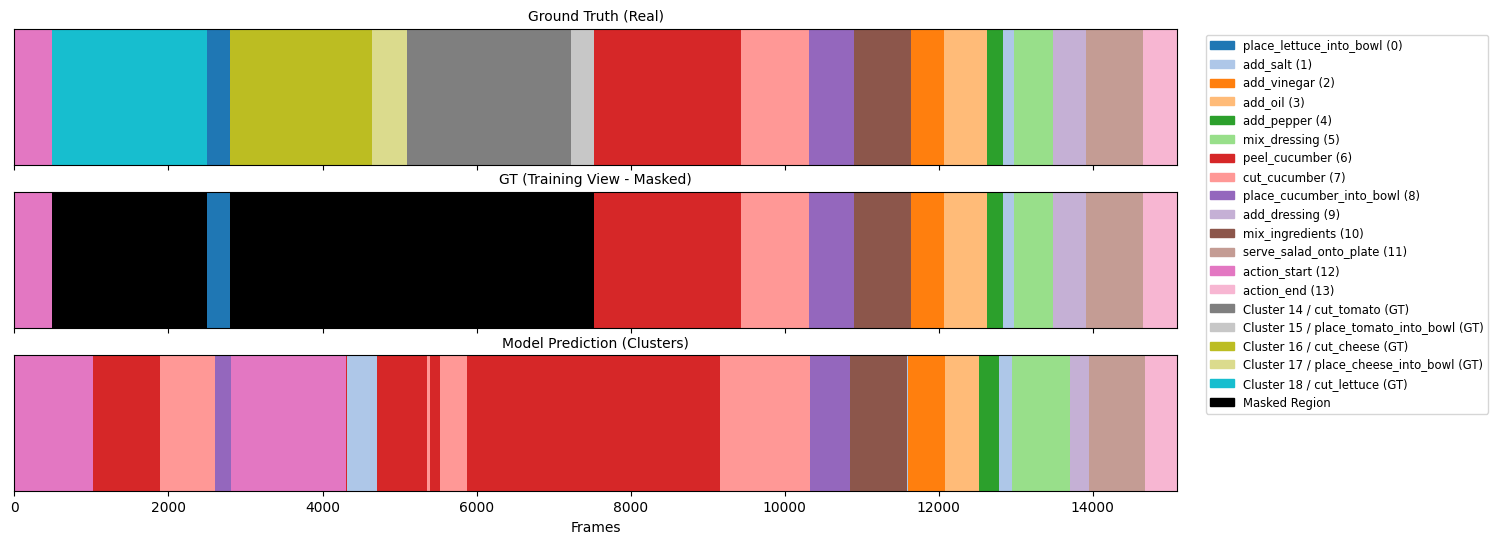

In [64]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import torch
from matplotlib.colors import ListedColormap
from eval.evaluator import Evaluator

for batch_test in data_loader_test:
    features = batch_test["features"]
    unknown_mask = batch_test["unknown_mask"]
    target_truth = batch_test["target_truth"]
    padding_mask = batch_test["padding_mask"]
    labels_dict = batch_test["labels_dict"]
    remap_dict = batch_test["remap_dict"]
    target_start = batch_test['target_start']
    target_end = batch_test['target_end']
    
# --- KONFIGURATION ---
NUM_KNOWNS = 14  # Anzahl Knowns (0-13)

# 1. Daten aus dem Batch holen
# Wir gehen davon aus, dass 'features', 'padding_mask', 'target_truth', etc. schon Variablen sind
# oder aus dem batch dict kommen.

# Model Prediction holen
res = get_model_pred(features.to('cuda'), padding_mask.to('cuda')).squeeze(0).cpu()
res_np = res.numpy()

patch_mask = _generate_structured_mask(features.to('cuda'),0.85,128)

patch_mask = patch_mask.squeeze(0).cpu().numpy().astype(bool)
pad_mask_np = padding_mask.squeeze(0).cpu().numpy().astype(bool)
unknown_mask_np = unknown_mask.squeeze(0).cpu().numpy().astype(bool)
target_truth_np = target_truth.squeeze(0).cpu().numpy()
patch_mask = patch_mask & pad_mask_np
# Filtern (Padding weg)

target_truth_valid = target_truth_np[pad_mask_np]
unknown_mask_valid = unknown_mask_np[pad_mask_np]

res_valid = res_np[pad_mask_np]

target_truth = target_truth.cpu()
padding_mask = padding_mask.cpu()
unknown_mask = unknown_mask.cpu()



# --- 2. ID-Mapping aus dem Batch nutzen (DER FIX) ---
# Du hast gesagt: remap_dict = batch["remap_dict"] (oder labels_dict)
# Dieses Dict ist wahrscheinlich: {'cut_tomato': 0, 'action_start': 12, ...}
# Wir brauchen es andersherum: {0: 'cut_tomato', 12: 'action_start'}

# Annahme: remap_dict ist das Dictionary aus deinem Batch
# Falls es im Batch ein Array/List ist (wegen Collate), nimm das erste Element.
raw_dict = batch_test["labels_dict"] # oder batch["remap_dict"]
if isinstance(raw_dict, list): # Falls Collate daraus eine Liste gemacht hat
    raw_dict = raw_dict[0]

# Umdrehen: ID -> Name
id_to_name = {v: k for k, v in raw_dict.items()}

# --- 3. Farb-Palette erstellen ---
max_id_gt = target_truth_valid.max()
max_id_pred = res_valid.max()
max_id_total = max(max_id_gt, max_id_pred)

# Farben stapeln
colors1 = plt.get_cmap('tab20').colors
colors2 = plt.get_cmap('tab20b').colors
colors3 = plt.get_cmap('tab20c').colors
base_colors = np.vstack((colors1, colors2, colors3))

# Palette erweitern falls nötig
while len(base_colors) <= max_id_total:
    base_colors = np.vstack((base_colors, base_colors))

# Schwarz für Masked GT am Ende anfügen
color_lut = base_colors[:max_id_total + 2].copy()
BLACK_ID = len(color_lut) - 1
color_lut[BLACK_ID] = [0.0, 0.0, 0.0] 

# --- 4. Plot-Daten vorbereiten ---

# GT Real: Zeigt alles in Farbe (auch die Unknowns, wie sie im Dataset heißen)
gt_full = target_truth_valid

# GT Masked: Zeigt Unknowns als Schwarz (Was das Modell "nicht weiß")
gt_masked = target_truth_valid.copy()
# Hier nutzen wir die unknown_mask vom Training -> Alles >= 14 wird schwarz
gt_masked[unknown_mask_valid] = BLACK_ID 
#gt_masked[patch_mask] = BLACK_ID 

# Prediction: Zeigt Knowns (0-13) und gefundene Cluster (14+)
pred_full = res_valid 

plots_data = [
    ("Ground Truth (Real)", gt_full),      
    ("GT (Training View - Masked)", gt_masked),
    ("Model Prediction (Clusters)", pred_full) 
]

# --- 5. Plotten ---
fig, axs = plt.subplots(nrows=len(plots_data), ncols=1, figsize=(15, 6), sharex=True)
if len(plots_data) == 1: axs = [axs]

for i, (title, data_indices) in enumerate(plots_data):
    # Mapping ID -> RGB
    rgb_image = color_lut[data_indices]
    rgb_image = rgb_image[np.newaxis, :, :] 
    
    axs[i].imshow(rgb_image, aspect='auto', interpolation='nearest')
    axs[i].set_title(title, fontsize=10)
    axs[i].set_yticks([]) 
    if i == len(plots_data) - 1: axs[i].set_xlabel("Frames")

# --- 6. Legende (Jetzt 100% korrekt durch Dict) ---
patches = []

# A. Known Actions (IDs 0 bis NUM_KNOWNS-1)
# Wir iterieren durch 0..13 und schauen im Dict nach dem Namen
for i in range(NUM_KNOWNS):
    if i in id_to_name:
        name = id_to_name[i]
        color = color_lut[i]
        patches.append(mpatches.Patch(color=color, label=f"{name} ({i})"))

# B. Unknowns & Cluster
# Wir sammeln alle IDs, die > 13 sind und im Plot vorkommen
unique_ids_in_plot = np.unique(np.concatenate([gt_full, pred_full]))
unknown_ids = [uid for uid in unique_ids_in_plot if uid >= NUM_KNOWNS and uid != BLACK_ID]

for uid in sorted(unknown_ids):
    color = color_lut[uid]
    label = f"Cluster {uid}"
    
    # Wenn wir für diese ID einen Namen im GT haben, zeigen wir ihn an
    # (Das gilt für die IDs 14-18, die im GT vorkommen)
    if uid in id_to_name:
        real_name = id_to_name[uid]
        label += f" / {real_name} (GT)"
    
    patches.append(mpatches.Patch(color=color, label=label))

# C. Schwarz
patches.append(mpatches.Patch(color=[0,0,0], label="Masked Region"))

axs[0].legend(handles=patches, bbox_to_anchor=(1.02, 1), loc='upper left', ncol=1, fontsize='small')

plt.tight_layout()
plt.show()




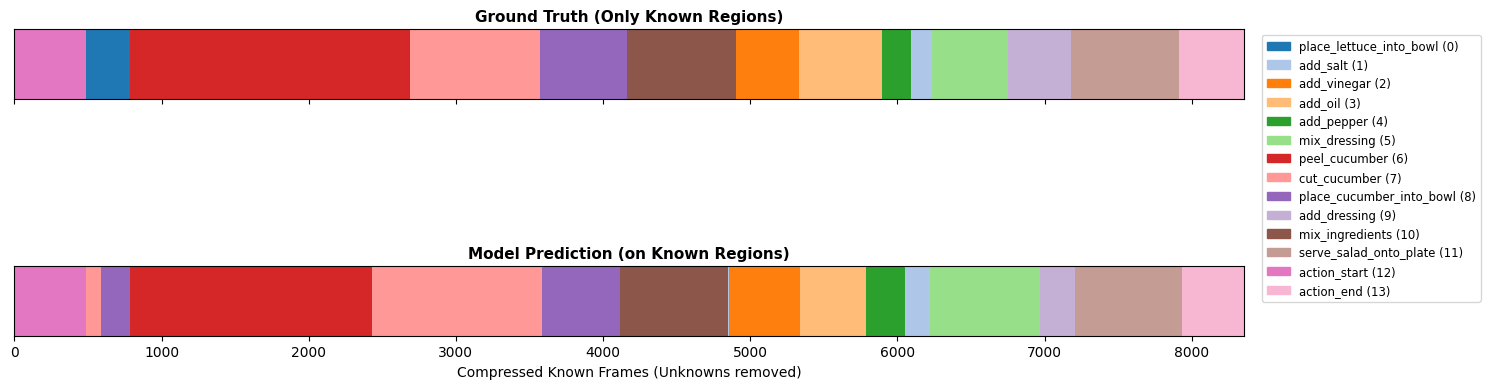

Ursprüngliche Frames: 15091
Frames nach Rausschneiden der Unknowns: 8355
------------------------------
ANALYSE: BEKANNTE BEREICHE
------------------------------
Frames (nur Knowns): 8355
Korrekt klassifiziert: 7239
MoF (auf Known Regions): 86.64%
------------------------------
Accuracy place_lettuce_into_bowl: 0.00% (294 Frames)
Accuracy add_salt            : 86.90% (145 Frames)
Accuracy add_vinegar         : 100.00% (431 Frames)
Accuracy add_oil             : 80.21% (561 Frames)
Accuracy add_pepper          : 77.50% (200 Frames)
Accuracy mix_dressing        : 100.00% (511 Frames)
Accuracy peel_cucumber       : 86.20% (1906 Frames)
Accuracy cut_cucumber        : 100.00% (883 Frames)
Accuracy place_cucumber_into_bowl: 89.61% (587 Frames)
Accuracy add_dressing        : 48.84% (430 Frames)
Accuracy mix_ingredients     : 92.97% (740 Frames)
Accuracy serve_salad_onto_plate: 96.17% (732 Frames)
Accuracy action_start        : 100.00% (492 Frames)
Accuracy action_end          : 94.81% (443 Fr

In [65]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import torch

# --- 1. DATEN VORBEREITEN (Wie bisher) ---
# (Ich gehe davon aus, dass 'batch_test', 'res_np', 'pad_mask_np', 
# 'unknown_mask_np', 'target_truth_np' wie in deinem Code geladen wurden)

# Wir filtern hier erst das Padding weg
target_truth_valid = target_truth_np[pad_mask_np]
unknown_mask_valid = unknown_mask_np[pad_mask_np]
res_valid = res_np[pad_mask_np]

# --- DER "RAUSSCHNEID"-SCHRITT ---
# Wir erstellen eine Maske für alle Frames, die WIRKLICH Knowns sind (GT 0-13)
# Das entspricht: Nicht-Padding und Nicht-Unknown
is_known_frame = ~unknown_mask_valid

# Wir schneiden die Zeitreihen hart zu (Slicing)
# Die Zeitachse wird dadurch verkürzt!
gt_cut = target_truth_valid[is_known_frame]
pred_cut = res_valid[is_known_frame]

# --- 2. ID-MAPPING ---
raw_dict = batch_test["labels_dict"]
if isinstance(raw_dict, list): raw_dict = raw_dict[0]
id_to_name = {v: k for k, v in raw_dict.items()}

# --- 3. FARB-PALETTE ---
max_id = max(gt_cut.max(), pred_cut.max())
colors = plt.get_cmap('tab20').colors
color_lut = np.array(colors)
while len(color_lut) <= max_id:
    color_lut = np.vstack((color_lut, color_lut))

# --- 4. PLOT-DATEN ---
# Wir zeigen jetzt nur noch zwei Balken: Das was die GT will und was das Modell dort tut
plots_data = [
    ("Ground Truth (Only Known Regions)", gt_cut),
    ("Model Prediction (on Known Regions)", pred_cut)
]

# --- 5. PLOTTEN ---
fig, axs = plt.subplots(nrows=len(plots_data), ncols=1, figsize=(15, 4), sharex=True)

for i, (title, data_indices) in enumerate(plots_data):
    # Mapping ID -> RGB
    rgb_image = color_lut[data_indices]
    rgb_image = rgb_image[np.newaxis, :, :] 
    
    axs[i].imshow(rgb_image, aspect='auto', interpolation='nearest')
    axs[i].set_title(title, fontsize=11, fontweight='bold')
    axs[i].set_yticks([]) 
    if i == len(plots_data) - 1: 
        axs[i].set_xlabel("Compressed Known Frames (Unknowns removed)")

# --- 6. LEGENDE (Nur für die vorkommenden Knowns) ---
patches = []
# Wir schauen welche IDs in den gefilterten Daten wirklich vorkommen
present_ids = np.unique(np.concatenate([gt_cut, pred_cut]))

for i in sorted(present_ids):
    if i in id_to_name:
        name = id_to_name[i]
        color = color_lut[i]
        patches.append(mpatches.Patch(color=color, label=f"{name} ({i})"))

# Legende rechts platzieren
axs[0].legend(handles=patches, bbox_to_anchor=(1.01, 1), loc='upper left', ncol=1, fontsize='small')

plt.tight_layout()
plt.show()

# Kurze Statistik-Ausgabe
print(f"Ursprüngliche Frames: {len(target_truth_valid)}")
print(f"Frames nach Rausschneiden der Unknowns: {len(gt_cut)}")
# --- 7. MoF BERECHNUNG FÜR DIE BEKANNTEN BEREICHE ---

# Anzahl der übereinstimmenden Frames
correct_frames = np.sum(gt_cut == pred_cut)
total_frames = len(gt_cut)

# MoF in Prozent
mof_knowns = (correct_frames / total_frames) * 100

print("-" * 30)
print(f"ANALYSE: BEKANNTE BEREICHE")
print("-" * 30)
print(f"Frames (nur Knowns): {total_frames}")
print(f"Korrekt klassifiziert: {correct_frames}")
print(f"MoF (auf Known Regions): {mof_knowns:.2f}%")
print("-" * 30)

# OPTIONAL: MoF pro Klasse (hilfreich um zu sehen, welche Klasse am meisten Probleme macht)
present_classes = np.unique(gt_cut)
for cls_id in present_classes:
    if cls_id in id_to_name:
        cls_mask = (gt_cut == cls_id)
        cls_correct = np.sum(pred_cut[cls_mask] == cls_id)
        cls_total = np.sum(cls_mask)
        cls_acc = (cls_correct / cls_total) * 100
        print(f"Accuracy {id_to_name[cls_id]:<20}: {cls_acc:.2f}% ({cls_total} Frames)")
        
        
    

Vorhandene Klassen in Train-Fenster: tensor([10, 14, 15])
Vorhandene Klassen in Test-Fenster: tensor([10, 14, 15])


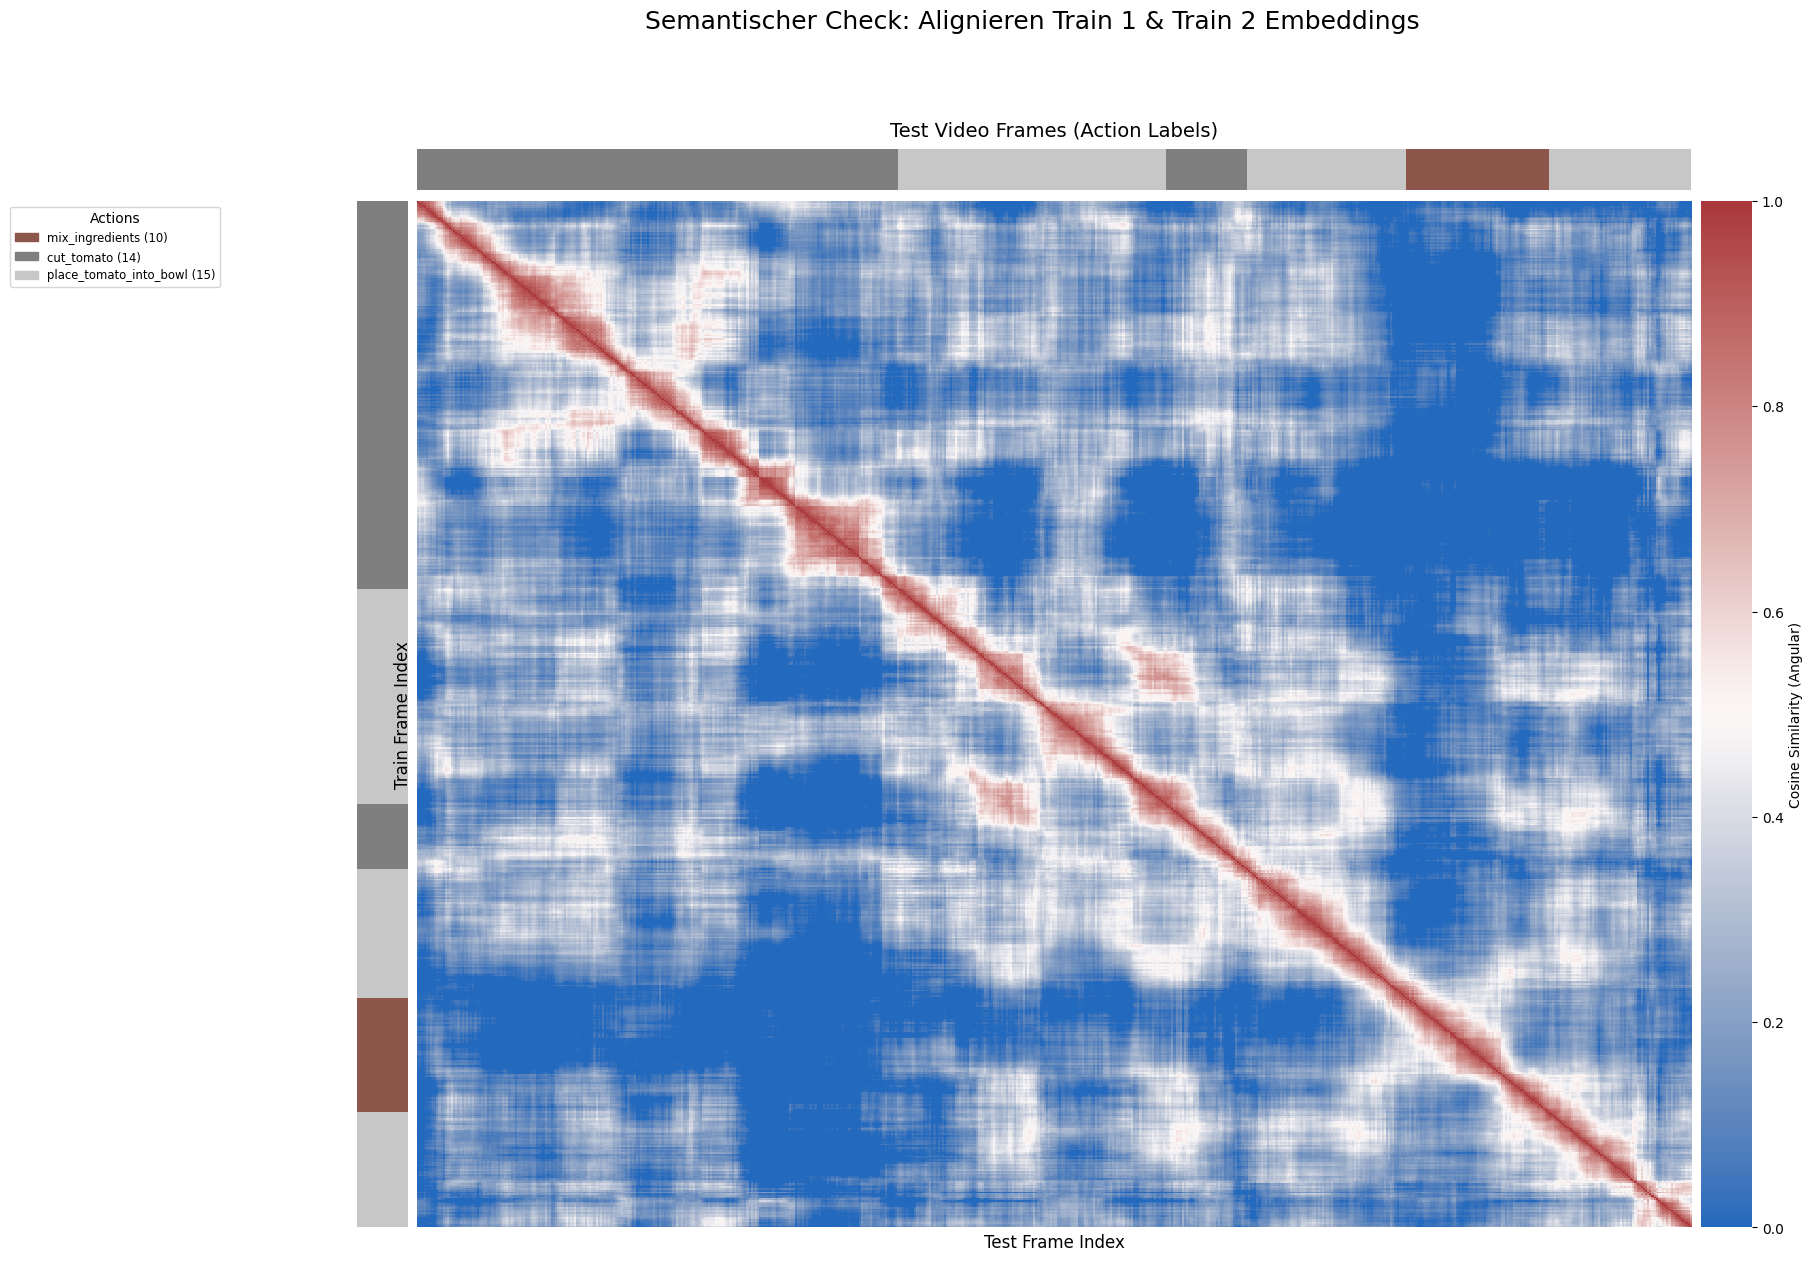

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
import numpy as np

def get_alignment_data(model, train_batch, test_batch, device, num_frames=2000):
    """
    Inferiert Embeddings für ein Train- und ein Test-Video und berechnet die Ähnlichkeit.
    """
    model.eval()
    model.to(device)
    
 
    
    with torch.no_grad():
        # Inferenz
        start_one = 3900
        start_two =3900
        out_train = model(train_batch["features"].to(device), None, train_batch["padding_mask"].to(device))
        out_test = model(train_batch["features"].to(device), None, train_batch["padding_mask"].to(device))
        
        # Embeddings extrahieren & normalisieren (Angular Space)
        # Shape: [num_frames, d_model]
        # 1. Rohe Embeddings extrahieren (noch nicht normalisiert!)
        raw_train = out_train["embeddings"][0] # [T, 256]
        raw_test = out_test["embeddings"][0]   # [T, 256]

        #raw_train = train_batch["features"].to(device)[0]
        #raw_test = train_batch["features"].to(device)[0]

        # --- DER CENTERING FIX ---
        # Wir berechnen den Mittelwert über das GESAMTE Video (oder den Batch)
        # Das verschiebt den Schwerpunkt der Wolke auf den Nullpunkt.
        mean_train = raw_train.mean(dim=0, keepdim=True)
        mean_test = raw_test.mean(dim=0, keepdim=True)

        centered_train = raw_train - mean_train
        centered_test = raw_test - mean_test
        # --------------------------

        # 2. Slicing der gewünschten Fenster aus den zentrierten Daten
        # Danach L2-Normalisierung für den Angular Space
        emb_train = F.normalize(centered_train[start_one:start_one+num_frames, :], p=2, dim=-1)
        emb_test = F.normalize(centered_test[start_two:start_two+num_frames, :], p=2, dim=-1)
        
        # 3. Ground Truth Labels extrahieren (bleibt gleich)
        gt_train = train_batch["target_truth"][0, start_one:start_one+num_frames].cpu().numpy()
        gt_test = test_batch["target_truth"][0, start_two:start_two+num_frames].cpu().numpy()
        
        print("Vorhandene Klassen in Train-Fenster:", torch.unique(torch.tensor(gt_train)))
        print("Vorhandene Klassen in Test-Fenster:", torch.unique(torch.tensor(gt_test)))

    # 4. Ähnlichkeitsmatrix berechnen (Cosine Similarity via MatMul)
    # Da wir zentriert und normalisiert haben, ist das Ergebnis jetzt 
    # über die gesamte Kugel verteilt (-1.0 bis 1.0)
    similarity_matrix = torch.matmul(emb_train, emb_test.t()).cpu().numpy()

    return similarity_matrix, gt_train, gt_test

def plot_alignment_matrix(similarity_matrix, gt_train, gt_test, color_lut, id_to_name, title="Cross-Domain Affinity"):
    """
    Erstellt eine Heatmap mit den EXAKT gleichen Farben wie im Bar-Plot.
    """
    fig = plt.figure(figsize=(18, 14))
    
    # Grid-Layout: [Links-Labels, Haupt-Heatmap, Colorbar-Platz]
    gs = plt.GridSpec(2, 3, 
                      width_ratios=[1, 25, 1], 
                      height_ratios=[1, 25], 
                      hspace=0.02, wspace=0.02)

    ax_top = fig.add_subplot(gs[0, 1])
    ax_left = fig.add_subplot(gs[1, 0])
    ax_main = fig.add_subplot(gs[1, 1], sharex=ax_top, sharey=ax_left)
    ax_cbar = fig.add_subplot(gs[1, 2])

    # --- DIE FARB-LOGIK ---
    # Wir erstellen eine Matplotlib-Colormap aus deiner color_lut
    custom_cmap = ListedColormap(color_lut)
    # vmin und vmax müssen den Index-Bereich deiner color_lut abdecken
    v_min = 0
    v_max = len(color_lut) - 1

    # 1. Test-Labels (Oben)
    ax_top.imshow(gt_test[None, :], aspect='auto', cmap=custom_cmap, 
                  interpolation='nearest', vmin=v_min, vmax=v_max)
    ax_top.set_axis_off()
    ax_top.set_title("Test Video Frames (Action Labels)", fontsize=14, pad=10)

    # 2. Train-Labels (Links)
    ax_left.imshow(gt_train[:, None], aspect='auto', cmap=custom_cmap, 
                   interpolation='nearest', vmin=v_min, vmax=v_max)
    ax_left.set_axis_off()

    # 3. Haupt-Heatmap (Ähnlichkeit)
    sns.heatmap(similarity_matrix, ax=ax_main, cmap='vlag', center=0.5, 
                vmin=0, vmax=1, cbar_ax=ax_cbar, 
                cbar_kws={'label': 'Cosine Similarity (Angular)'})
    
    ax_main.set_xlabel("Test Frame Index", fontsize=12)
    ax_main.set_ylabel("Train Frame Index", fontsize=12)
    ax_main.set_xticks([])
    ax_main.set_yticks([])

    # --- LEGENDE HINZUFÜGEN (analog zum anderen Plot) ---
    patches = []
    # Alle IDs finden, die in diesen Ausschnitten vorkommen
    unique_ids = np.unique(np.concatenate([gt_train, gt_test]))
    for uid in sorted(unique_ids):
        if uid == len(color_lut) - 1: # Black / Masked
            patches.append(mpatches.Patch(color=[0,0,0], label="Masked"))
        elif uid in id_to_name:
            patches.append(mpatches.Patch(color=color_lut[int(uid)], label=f"{id_to_name[uid]} ({int(uid)})"))
        else:
            patches.append(mpatches.Patch(color=color_lut[int(uid)], label=f"Cluster {int(uid)}"))

    # Legende ganz links außen oder rechts platzieren
    ax_main.legend(handles=patches, bbox_to_anchor=(-0.15, 1.0), loc='upper right', 
                   fontsize='small', title="Actions")

    plt.suptitle(title, fontsize=18, y=0.98)
    plt.show()

# --- Ausführung ---
# Wir nutzen die Variablen (color_lut, id_to_name), die du im vorherigen Block definiert hast

# --- Ausführung ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
iterator = iter(data_loader_test)
#b_train1 = next(iterator)
#b_train2 = next(iterator)
# 1. Daten berechnen
sim_mat, gt_tr, gt_te = get_alignment_data(
    model, 
    b_train1, 
    b_train1, 
    DEVICE, 
    num_frames=600
)

# 2. Visualisieren
plot_alignment_matrix(
    sim_mat, 
    gt_tr, 
    gt_te, 
    color_lut,   # <--- Hier übergeben
    id_to_name,  # <--- Hier übergeben
    title="Semantischer Check: Alignieren Train 1 & Train 2 Embeddings"
)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import numpy as np
import torch
import torch.nn.functional as F
start_one = 3900
start_two =3900

def analyze_centered_raw_features(model,train_batch, device, eps=0.5, min_samples=30):
    # 1. Rohe Features holen [T, 2048]
    out_train = model(train_batch["features"].to(device), None, train_batch["padding_mask"].to(device))["embeddings"]
    out_test = model(train_batch["features"].to(device), None, train_batch["padding_mask"].to(device))
    
    print(out_train.shape)
    raw_feats = out_train[0][start_one:start_one+600]
    gt = train_batch["target_truth"][0,start_one:start_one+600].cpu().numpy()
    
    # 2. Centering Fix (Den I3D-Klumpen auf den Nullpunkt schieben)
    video_mean = raw_feats.mean(dim=0, keepdim=True)
    centered_feats = raw_feats - video_mean
    
    # 3. Normalisierung (Angular Space ist Pflicht nach dem Centering)
    normed_feats = F.normalize(centered_feats, p=2, dim=-1).cpu().numpy()
    
    # 4. DBSCAN auf den zentrierten Roh-Features
    print(f"Starte DBSCAN auf zentrierten I3D-Features (eps={eps})...")
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(normed_feats)
    cluster_labels = db.labels_
    
    # 5. Visualisierung
    T = len(gt)
    fig, ax = plt.subplots(2, 1, figsize=(18, 5), sharex=True)
    
    # Plot 1: Ground Truth
    ax[0].imshow(gt[None, :], aspect='auto', interpolation='nearest', cmap='tab20')
    ax[0].set_yticks([])
    ax[0].set_ylabel("Ground\nTruth", rotation=0, labelpad=40, va='center', fontweight='bold')
    
    # Plot 2: DBSCAN Cluster
    # -1 (Noise) wird schwarz dargestellt
    ax[1].imshow(cluster_labels[None, :], aspect='auto', interpolation='nearest', cmap='Set1')
    ax[1].set_yticks([])
    ax[1].set_ylabel("DBSCAN\nCentered Raw", rotation=0, labelpad=40, va='center', fontweight='bold')
    
    plt.xlabel("Frames")
    plt.suptitle("Diagnose: Hilft Centering den rohen I3D Features?", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # 6. Purity Analyse
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    print(f"Gefundene Cluster: {n_clusters}")
    if n_clusters > 0:
        for c in range(min(n_clusters, 10)):
            mask = (cluster_labels == c)
            unique, counts = np.unique(gt[mask], return_counts=True)
            purity = 100 * np.max(counts) / np.sum(mask)
            print(f"Cluster {c}: Größe {np.sum(mask)} | Dominante Action: {unique[np.argmax(counts)]} | Reinheit: {purity:.1f}%")

# Aufruf
analyze_centered_raw_features(model,b_train1, "cpu", eps=0.5)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)